In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

# masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
        0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
        0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
        1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
        0.33863009])
# total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses)
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33
# UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
# projected separation divided by effective radius from Georgiev
#UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
      # 0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
       #1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
       #0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
       #1.22266667])
# physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e

# a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

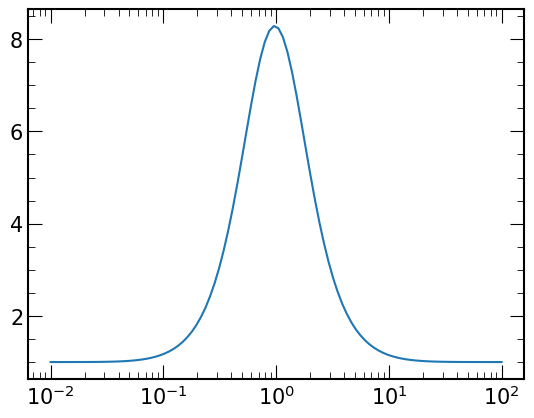

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


<ipython-input-3-d76d9a7acbd3>:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
12.120864152908325
2.1 0.1
finished until t = 0.0 1.247981309890747


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 0.5 7.350334882736206
finished until t = 1.0 16.600341081619263
finished until t = 1.5 28.344151973724365
finished until t = 2.0 41.65343689918518
finished until t = 2.5 56.64813232421875
finished until t = 3.0 73.14570379257202
finished until t = 3.5 90.96993279457092
finished until t = 4.0 110.05533504486084
finished until t = 4.5 130.5626883506775
finished until t = 5.0 152.87500381469727
finished until t = 5.5 176.2475037574768
finished until t = 6.0 200.86199522018433
finished until t = 6.5 226.97446131706238
finished until t = 7.0 253.91217756271362
finished until t = 7.5 282.68068838119507
finished until t = 8.0 312.57254910469055
finished until t = 8.5 343.40715646743774
finished until t = 9.0 375.4710154533386
finished until t = 9.5 408.9662535190582
finished until t = 10.0 443.47772121429443


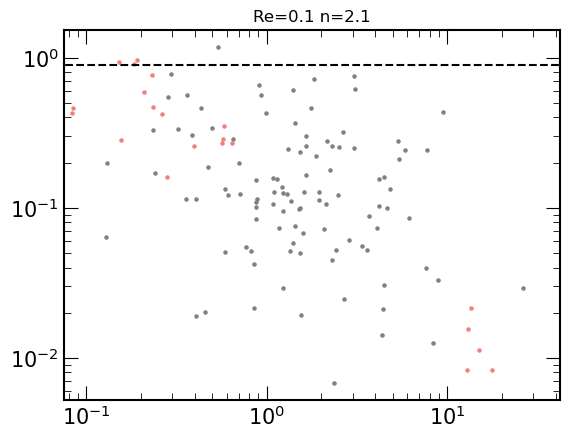

Calculating NFW Energies and Weights


<ipython-input-3-d76d9a7acbd3>:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
9.978191375732422
2.1 0.3
finished until t = 0.0 0.6768248081207275
finished until t = 0.5 6.420090436935425
finished until t = 1.0 18.133259534835815
finished until t = 1.5 35.20657777786255
finished until t = 2.0 57.27604842185974
finished until t = 2.5 83.92635154724121
finished until t = 3.0 114.32475185394287
finished until t = 3.5 148.39185094833374
finished until t = 4.0 186.70220160484314
finished until t = 4.5 228.40304684638977
finished until t = 5.0 274.17156291007996
finished until t = 5.5 323.0921971797943
finished until t = 6.0 376.00191378593445
finished until t = 6.5 432.07034397125244
finished until t = 7.0 491.22270703315735
finished until t = 7.5 553.7824075222015
finished until t = 8.0 618.7343602180481
finished until t = 8.5 687.0727818012238
finished until t = 9.0 759.0935518741608
finished until t = 9.5 833.7081503868103
finished until t = 10.0 911.9830071926117


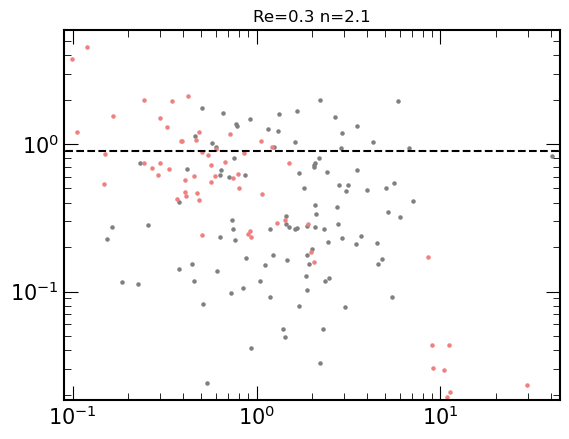

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.917882680892944
2.1 0.5
finished until t = 0.0 0.6764287948608398
finished until t = 0.5 6.1864728927612305
finished until t = 1.0 16.697304487228394
finished until t = 1.5 32.49459624290466
finished until t = 2.0 53.30891513824463
finished until t = 2.5 79.5909116268158
finished until t = 3.0 110.73970866203308
finished until t = 3.5 147.36803221702576
finished until t = 4.0 188.93633341789246
finished until t = 4.5 234.9955620765686
finished until t = 5.0 285.69784450531006
finished until t = 5.5 340.58656454086304
finished until t = 6.0 400.30006551742554
finished until t = 6.5 464.181706905365
finished until t = 7.0 532.5926468372345
finished until t = 7.5 605.2047066688538
finished until t = 8.0 682.7848870754242
finished until t = 8.5 764.3223221302032
finished until t = 9.0 850.2885463237762
finished until t = 9.5 938.8111407756805
finished until t = 10.0 1033.0406920909882


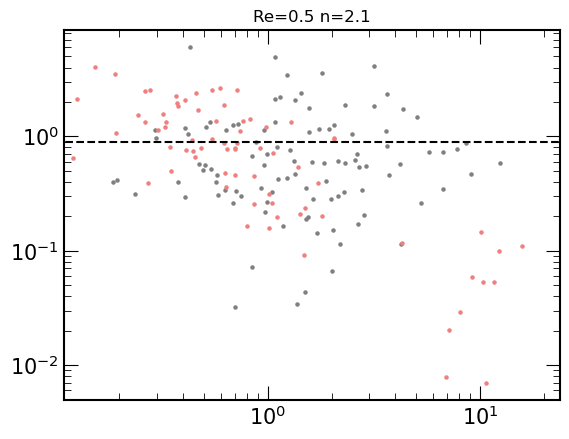

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.915270328521729
2.1 0.7
finished until t = 0.0 0.7871065139770508
finished until t = 0.5 6.11085319519043
finished until t = 1.0 15.916814804077148
finished until t = 1.5 31.014673948287964
finished until t = 2.0 50.80472207069397
finished until t = 2.5 75.82842421531677
finished until t = 3.0 106.37557482719421
finished until t = 3.5 141.4395158290863
finished until t = 4.0 181.470552444458
finished until t = 4.5 225.00670957565308
finished until t = 5.0 273.52613139152527
finished until t = 5.5 326.18631410598755
finished until t = 6.0 383.6396336555481
finished until t = 6.5 445.20646834373474
finished until t = 7.0 511.0982096195221
finished until t = 7.5 580.7352092266083
finished until t = 8.0 654.4181663990021
finished until t = 8.5 731.6051087379456
finished until t = 9.0 808.9705526828766
finished until t = 9.5 890.3055167198181
finished until t = 10.0 975.6169996261597


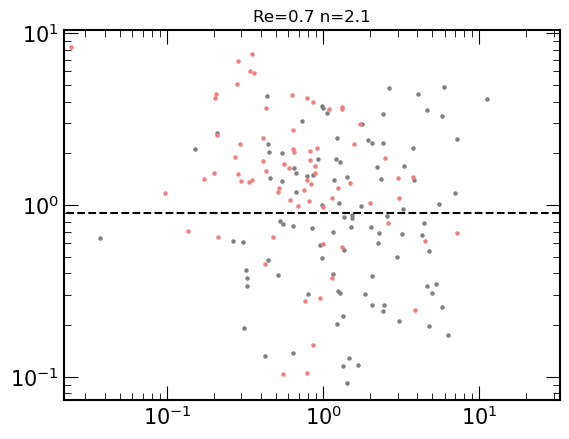

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.752852201461792
2.1 0.9
finished until t = 0.0 0.6844151020050049
finished until t = 0.5 5.697269439697266
finished until t = 1.0 15.634527206420898
finished until t = 1.5 29.609758853912354
finished until t = 2.0 48.085546016693115
finished until t = 2.5 71.18359160423279
finished until t = 3.0 98.64535999298096
finished until t = 3.5 131.0449743270874
finished until t = 4.0 167.60415387153625
finished until t = 4.5 208.88366866111755
finished until t = 5.0 255.38101267814636
finished until t = 5.5 306.553270816803
finished until t = 6.0 363.04879212379456
finished until t = 6.5 423.9332666397095
finished until t = 7.0 489.8431091308594
finished until t = 7.5 559.8378663063049
finished until t = 8.0 635.9472982883453
finished until t = 8.5 714.2790591716766
finished until t = 9.0 798.5821001529694
finished until t = 9.5 886.9461002349854
finished until t = 10.0 982.317254781723


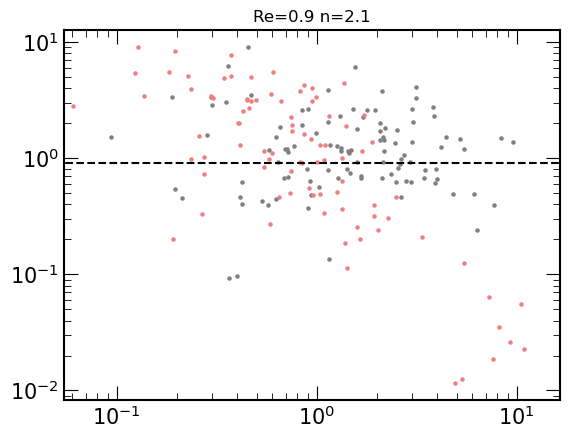

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.923562049865723
2.1 1.1
finished until t = 0.0 0.6371643543243408
finished until t = 0.5 4.8452794551849365
finished until t = 1.0 12.735799551010132
finished until t = 1.5 24.43766212463379
finished until t = 2.0 40.21118974685669
finished until t = 2.5 60.24862265586853
finished until t = 3.0 84.26571083068848
finished until t = 3.5 113.74303650856018
finished until t = 4.0 146.1700382232666
finished until t = 4.5 184.17490696907043
finished until t = 5.0 225.25324153900146
finished until t = 5.5 270.78979682922363
finished until t = 6.0 320.5572566986084
finished until t = 6.5 374.8839147090912
finished until t = 7.0 433.88897705078125
finished until t = 7.5 496.75164461135864
finished until t = 8.0 563.7681250572205
finished until t = 8.5 634.8911530971527
finished until t = 9.0 710.308219909668
finished until t = 9.5 789.6992547512054
finished until t = 10.0 873.1688103675842


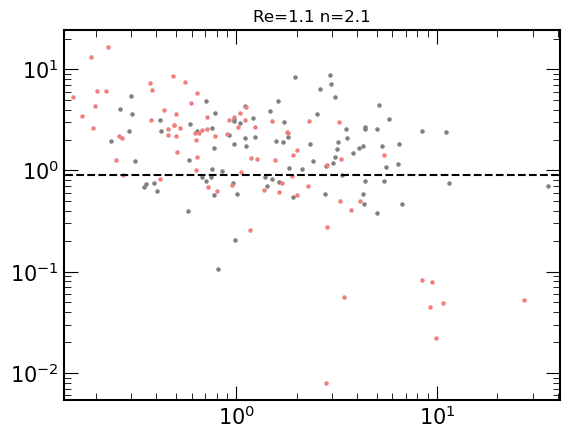

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.249724388122559
2.1 1.3
finished until t = 0.0 0.6165146827697754
finished until t = 0.5 4.547624111175537
finished until t = 1.0 11.868587493896484
finished until t = 1.5 22.55645990371704
finished until t = 2.0 36.65334343910217
finished until t = 2.5 54.32527446746826
finished until t = 3.0 75.61760306358337
finished until t = 3.5 100.46762371063232
finished until t = 4.0 129.05008101463318
finished until t = 4.5 161.73759293556213
finished until t = 5.0 198.72073912620544
finished until t = 5.5 239.93606901168823
finished until t = 6.0 285.5231246948242
finished until t = 6.5 334.00020360946655
finished until t = 7.0 386.40686416625977
finished until t = 7.5 442.63312554359436
finished until t = 8.0 502.8373930454254
finished until t = 8.5 566.76171875
finished until t = 9.0 634.7160577774048
finished until t = 9.5 706.5723366737366
finished until t = 10.0 781.9158322811127


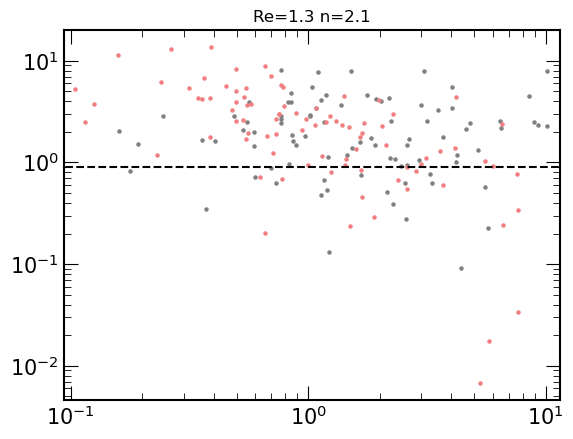

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.423197984695435
2.1 1.5
finished until t = 0.0 0.6054880619049072
finished until t = 0.5 4.624990701675415
finished until t = 1.0 11.92886471748352
finished until t = 1.5 22.619722843170166
finished until t = 2.0 36.649407625198364
finished until t = 2.5 54.14931392669678
finished until t = 3.0 74.93620610237122
finished until t = 3.5 99.13814425468445
finished until t = 4.0 126.8346426486969
finished until t = 4.5 158.14706110954285
finished until t = 5.0 193.20685386657715
finished until t = 5.5 231.27082228660583
finished until t = 6.0 273.5515990257263
finished until t = 6.5 318.8136179447174
finished until t = 7.0 365.0879566669464
finished until t = 7.5 411.4388883113861
finished until t = 8.0 460.6599471569061
finished until t = 8.5 512.7458341121674
finished until t = 9.0 567.7569072246552
finished until t = 9.5 625.8029346466064
finished until t = 10.0 686.8117387294769


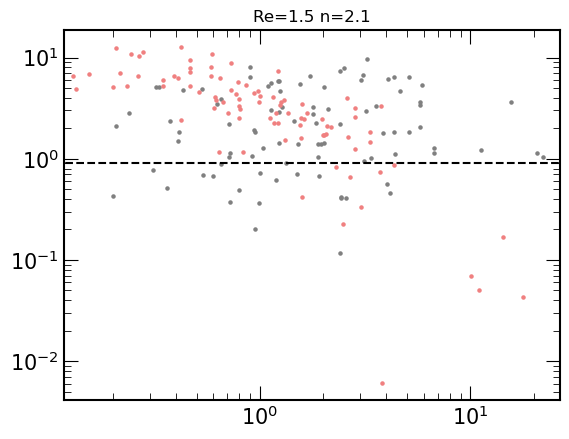

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.459729194641113
2.1 1.7
finished until t = 0.0 0.5650179386138916
finished until t = 0.5 4.597665309906006
finished until t = 1.0 12.095702409744263
finished until t = 1.5 23.30121111869812
finished until t = 2.0 38.31581211090088
finished until t = 2.5 56.816232681274414
finished until t = 3.0 79.15500998497009
finished until t = 3.5 105.13611340522766
finished until t = 4.0 135.05953001976013
finished until t = 4.5 169.14496517181396
finished until t = 5.0 206.89372563362122
finished until t = 5.5 248.5447874069214
finished until t = 6.0 293.46188163757324
finished until t = 6.5 342.17432928085327
finished until t = 7.0 393.5542573928833
finished until t = 7.5 448.49986839294434
finished until t = 8.0 507.2073287963867
finished until t = 8.5 569.0554432868958
finished until t = 9.0 634.3478527069092
finished until t = 9.5 703.0966925621033
finished until t = 10.0 775.2513768672943


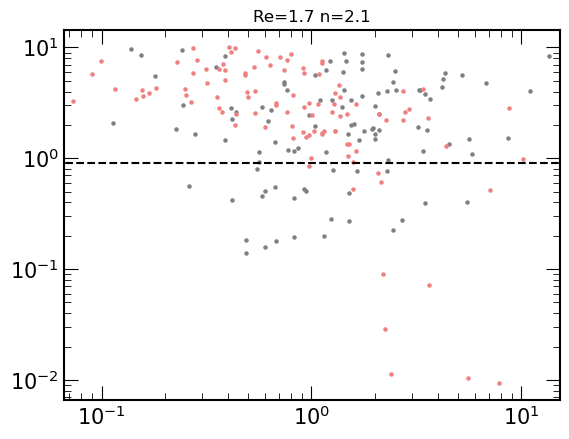

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.53063154220581
2.1 1.9
finished until t = 0.0 0.5466091632843018
finished until t = 0.5 4.253753662109375
finished until t = 1.0 11.068782091140747
finished until t = 1.5 21.060084104537964
finished until t = 2.0 34.015560150146484
finished until t = 2.5 50.13345217704773
finished until t = 3.0 69.57748174667358
finished until t = 3.5 92.12917971611023
finished until t = 4.0 117.80294442176819
finished until t = 4.5 146.77496004104614
finished until t = 5.0 179.00155782699585
finished until t = 5.5 214.51661896705627
finished until t = 6.0 253.34544849395752
finished until t = 6.5 295.6783094406128
finished until t = 7.0 341.6306929588318
finished until t = 7.5 391.30308532714844
finished until t = 8.0 444.89813256263733
finished until t = 8.5 502.34568643569946
finished until t = 9.0 563.5624735355377
finished until t = 9.5 628.6337831020355
finished until t = 10.0 697.4787843227386


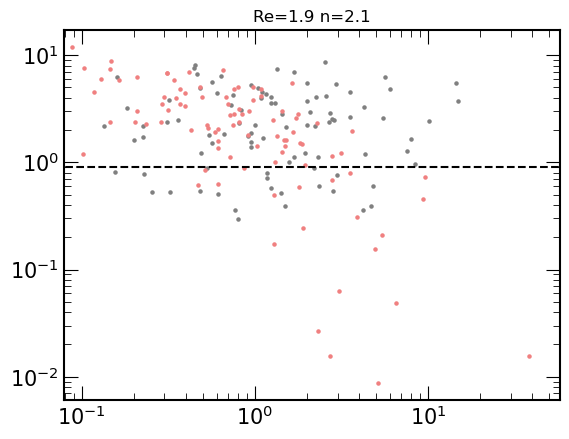

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.52232050895691
2.1 2.1
finished until t = 0.0 0.6183595657348633
finished until t = 0.5 4.680791616439819
finished until t = 1.0 12.224941968917847
finished until t = 1.5 23.238779306411743
finished until t = 2.0 37.77802348136902
finished until t = 2.5 55.87434411048889
finished until t = 3.0 77.29851579666138
finished until t = 3.5 103.92094659805298
finished until t = 4.0 133.76957201957703
finished until t = 4.5 168.15795850753784
finished until t = 5.0 206.53499841690063
finished until t = 5.5 248.7535765171051
finished until t = 6.0 294.8359410762787
finished until t = 6.5 345.4321541786194
finished until t = 7.0 393.5805997848511
finished until t = 7.5 443.9462764263153
finished until t = 8.0 497.470445394516
finished until t = 8.5 554.3843202590942
finished until t = 9.0 614.1106307506561
finished until t = 9.5 679.9431228637695
finished until t = 10.0 748.3175253868103


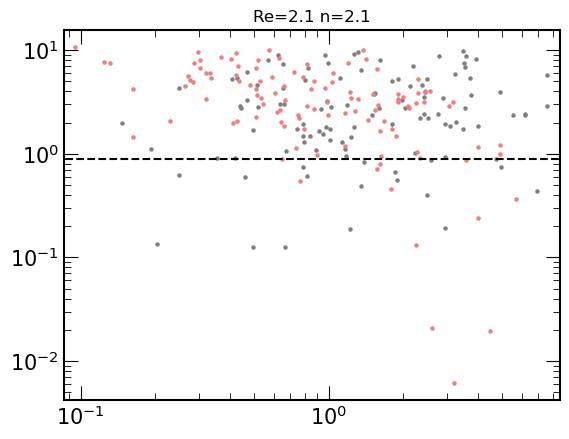

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.670825004577637
2.1 2.3
finished until t = 0.0 0.5442779064178467
finished until t = 0.5 3.719658136367798
finished until t = 1.0 9.104142427444458
finished until t = 1.5 17.981112480163574
finished until t = 2.0 28.64988946914673
finished until t = 2.5 42.15272259712219
finished until t = 3.0 58.55081820487976
finished until t = 3.5 78.3347635269165
finished until t = 4.0 100.86193943023682
finished until t = 4.5 125.93345093727112
finished until t = 5.0 154.14689755439758
finished until t = 5.5 185.05891299247742
finished until t = 6.0 218.93728184700012
finished until t = 6.5 255.72565174102783
finished until t = 7.0 295.9220929145813
finished until t = 7.5 336.6515874862671
finished until t = 8.0 380.5895574092865
finished until t = 8.5 427.1933524608612
finished until t = 9.0 476.6165997982025
finished until t = 9.5 528.914314031601
finished until t = 10.0 583.9968316555023


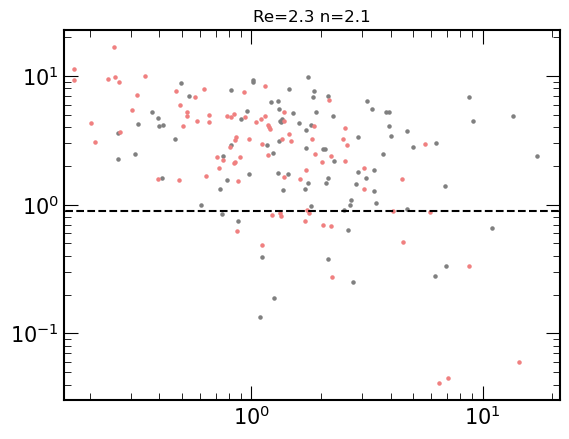

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.22350287437439
2.1 2.5
finished until t = 0.0 0.5055291652679443
finished until t = 0.5 3.8678972721099854
finished until t = 1.0 10.021178245544434
finished until t = 1.5 19.22527241706848
finished until t = 2.0 31.284752130508423
finished until t = 2.5 46.48565888404846
finished until t = 3.0 65.06617712974548
finished until t = 3.5 86.37160396575928
finished until t = 4.0 110.65424609184265
finished until t = 4.5 137.97163677215576
finished until t = 5.0 168.31567430496216
finished until t = 5.5 201.37047052383423
finished until t = 6.0 237.39935517311096
finished until t = 6.5 276.2971148490906
finished until t = 7.0 317.9150619506836
finished until t = 7.5 362.7474720478058
finished until t = 8.0 410.5491945743561
finished until t = 8.5 461.19667315483093
finished until t = 9.0 514.8506586551666
finished until t = 9.5 571.4169557094574
finished until t = 10.0 630.5536708831787


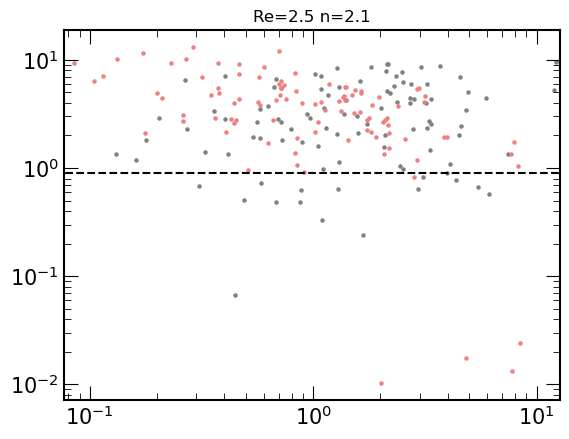

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.245281219482422
2.1 2.7
finished until t = 0.0 0.4946269989013672
finished until t = 0.5 3.777893304824829
finished until t = 1.0 9.993399620056152
finished until t = 1.5 19.041440725326538
finished until t = 2.0 31.249358654022217
finished until t = 2.5 46.51851439476013
finished until t = 3.0 64.59306645393372
finished until t = 3.5 85.82579970359802
finished until t = 4.0 109.61700654029846
finished until t = 4.5 135.8606345653534
finished until t = 5.0 165.00476741790771
finished until t = 5.5 197.1202940940857
finished until t = 6.0 232.17272281646729
finished until t = 6.5 270.20525550842285
finished until t = 7.0 311.2772252559662
finished until t = 7.5 355.395870923996
finished until t = 8.0 401.99342131614685
finished until t = 8.5 451.1404767036438
finished until t = 9.0 502.8528356552124
finished until t = 9.5 557.5507402420044
finished until t = 10.0 614.8167479038239


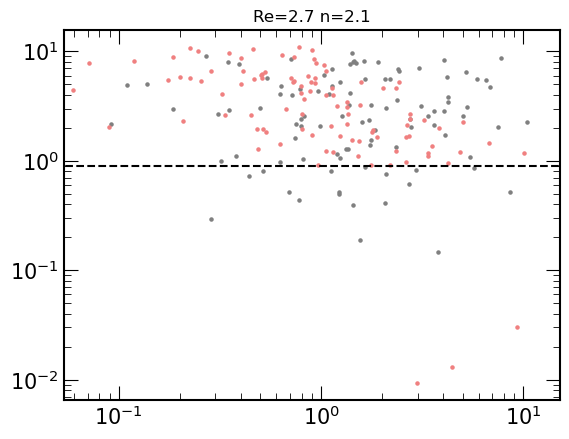

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.259825229644775
2.1 2.9
finished until t = 0.0 0.464324951171875
finished until t = 0.5 3.3575451374053955
finished until t = 1.0 8.836177825927734
finished until t = 1.5 17.16229748725891
finished until t = 2.0 28.075339317321777
finished until t = 2.5 41.62725114822388
finished until t = 3.0 57.78009843826294
finished until t = 3.5 76.9211151599884
finished until t = 4.0 98.6444947719574
finished until t = 4.5 123.10697817802429
finished until t = 5.0 150.31093764305115
finished until t = 5.5 180.52693510055542
finished until t = 6.0 213.65979671478271
finished until t = 6.5 249.6390929222107
finished until t = 7.0 288.34361481666565
finished until t = 7.5 329.8681390285492
finished until t = 8.0 373.6933455467224
finished until t = 8.5 420.1965479850769
finished until t = 9.0 469.51731514930725
finished until t = 9.5 521.5185437202454
finished until t = 10.0 576.3128039836884


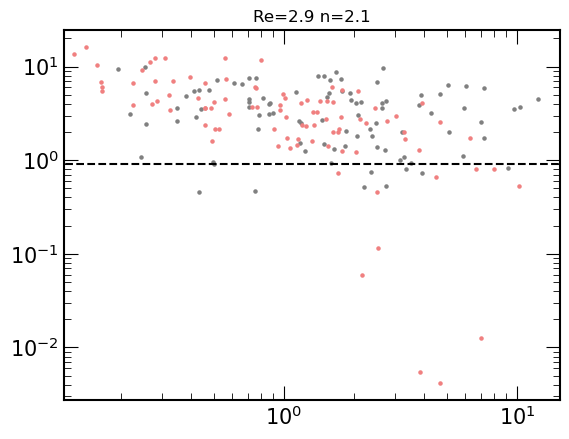

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.286638736724854
2.1 3.1
finished until t = 0.0 0.5062332153320312
finished until t = 0.5 3.8528993129730225
finished until t = 1.0 10.137125968933105
finished until t = 1.5 19.567379236221313
finished until t = 2.0 32.01716709136963
finished until t = 2.5 47.267398834228516
finished until t = 3.0 65.64377999305725
finished until t = 3.5 86.92716646194458
finished until t = 4.0 111.61389470100403
finished until t = 4.5 138.92471313476562
finished until t = 5.0 169.6492042541504
finished until t = 5.5 203.83711099624634
finished until t = 6.0 240.95379614830017
finished until t = 6.5 280.9897744655609
finished until t = 7.0 324.48039531707764
finished until t = 7.5 371.1394934654236
finished until t = 8.0 420.98363161087036
finished until t = 8.5 474.1872456073761
finished until t = 9.0 530.4605689048767
finished until t = 9.5 590.4067561626434
finished until t = 10.0 653.5015296936035


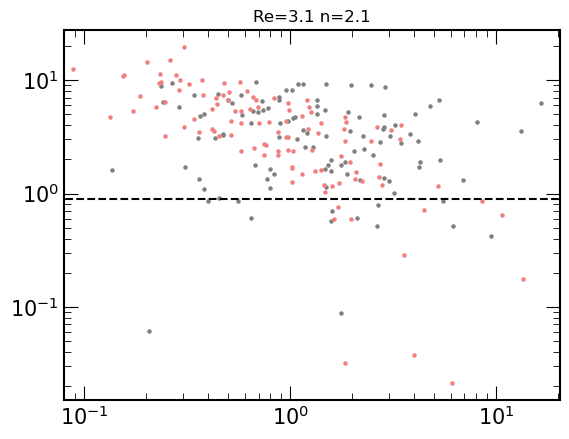

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
7.902141332626343
2.1 3.3
finished until t = 0.0 0.46082353591918945
finished until t = 0.5 3.284634828567505
finished until t = 1.0 8.326433420181274
finished until t = 1.5 15.413618564605713
finished until t = 2.0 25.137649297714233
finished until t = 2.5 36.789769649505615
finished until t = 3.0 51.02457141876221
finished until t = 3.5 67.5333149433136
finished until t = 4.0 86.6969861984253
finished until t = 4.5 108.09109210968018
finished until t = 5.0 132.0230119228363
finished until t = 5.5 158.66177821159363
finished until t = 6.0 187.54649710655212
finished until t = 6.5 217.84255361557007
finished until t = 7.0 250.56268095970154
finished until t = 7.5 285.2630524635315
finished until t = 8.0 322.4078779220581
finished until t = 8.5 362.5435540676117
finished until t = 9.0 404.7797381877899
finished until t = 9.5 449.19007873535156
finished until t = 10.0 495.77313590049744


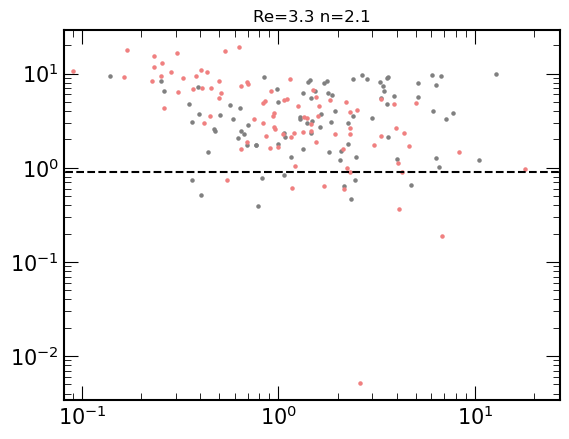

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
7.934812545776367
2.1 3.5
finished until t = 0.0 0.42354631423950195
finished until t = 0.5 2.739244222640991
finished until t = 1.0 7.139592409133911
finished until t = 1.5 13.520080089569092
finished until t = 2.0 21.970953941345215
finished until t = 2.5 32.471110820770264
finished until t = 3.0 45.03104496002197
finished until t = 3.5 59.29690957069397
finished until t = 4.0 75.89022469520569
finished until t = 4.5 94.442453622818
finished until t = 5.0 115.21161007881165
finished until t = 5.5 137.56142139434814
finished until t = 6.0 162.27139830589294
finished until t = 6.5 188.8212869167328
finished until t = 7.0 217.42953991889954
finished until t = 7.5 248.2827696800232
finished until t = 8.0 281.2715847492218
finished until t = 8.5 316.51590752601624
finished until t = 9.0 353.7116525173187
finished until t = 9.5 392.9206404685974
finished until t = 10.0 434.6197884082794


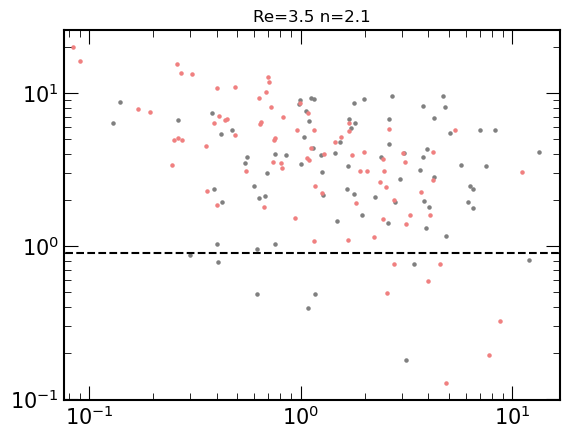

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
7.218834400177002
2.1 3.7
finished until t = 0.0 0.5141587257385254
finished until t = 0.5 3.754295587539673
finished until t = 1.0 9.42207646369934
finished until t = 1.5 17.73148798942566
finished until t = 2.0 28.763428926467896
finished until t = 2.5 42.61412191390991
finished until t = 3.0 59.103496074676514
finished until t = 3.5 78.69534659385681
finished until t = 4.0 101.05678272247314
finished until t = 4.5 125.38343572616577
finished until t = 5.0 152.67956256866455
finished until t = 5.5 182.79187655448914
finished until t = 6.0 215.1397349834442
finished until t = 6.5 250.1543366909027
finished until t = 7.0 288.05302691459656
finished until t = 7.5 328.85575795173645
finished until t = 8.0 371.79112124443054
finished until t = 8.5 417.24227809906006
finished until t = 9.0 465.4457447528839
finished until t = 9.5 516.0596034526825
finished until t = 10.0 570.0418825149536


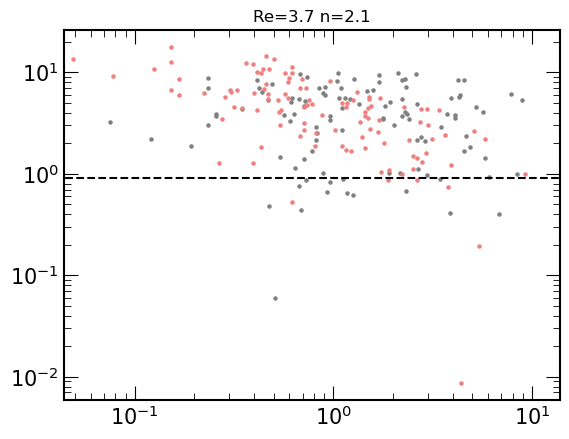

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
6.959116697311401
2.1 3.9
finished until t = 0.0 0.4769132137298584
finished until t = 0.5 3.385291576385498
finished until t = 1.0 8.390397310256958
finished until t = 1.5 16.323347806930542
finished until t = 2.0 26.108977794647217
finished until t = 2.5 38.429643392562866
finished until t = 3.0 52.853310108184814
finished until t = 3.5 69.51736450195312
finished until t = 4.0 88.79900884628296
finished until t = 4.5 110.31345510482788
finished until t = 5.0 134.09429907798767
finished until t = 5.5 160.43474459648132
finished until t = 6.0 188.71555304527283
finished until t = 6.5 219.60646748542786
finished until t = 7.0 252.66349625587463
finished until t = 7.5 288.2987904548645
finished until t = 8.0 325.66193151474
finished until t = 8.5 365.87413573265076
finished until t = 9.0 408.0244014263153
finished until t = 9.5 452.8055193424225
finished until t = 10.0 500.3786246776581


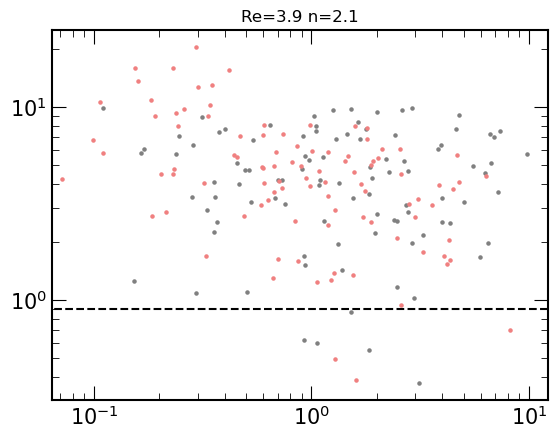

In [3]:
#NFW
n_values = [2.1]
R_e_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'ZoomNFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_ZoomNFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_ZoomNFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('ZoomNFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             
        